In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.19.0


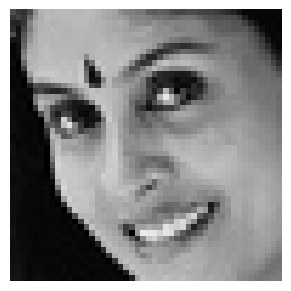

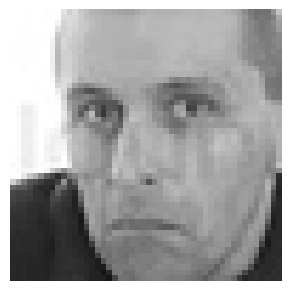

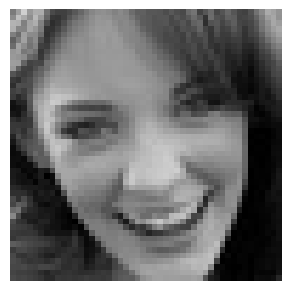

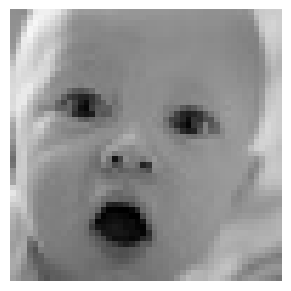

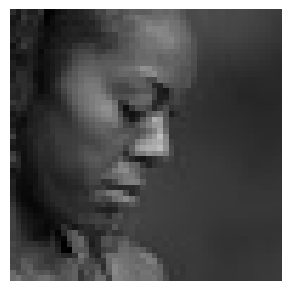

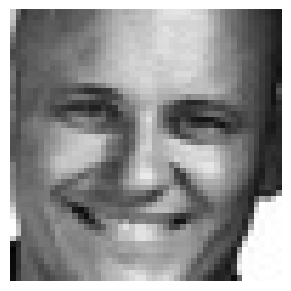

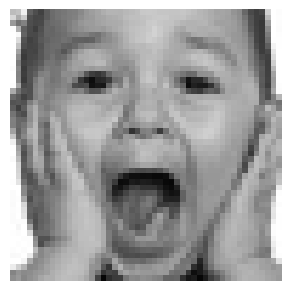

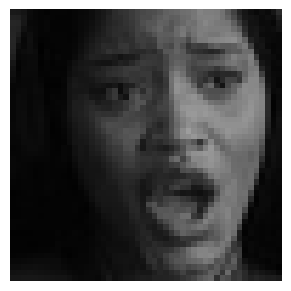

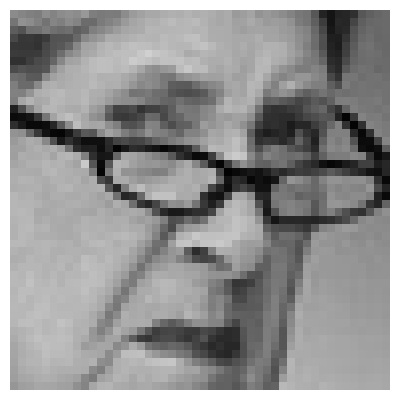

In [2]:
import matplotlib.pyplot as plt

images = glob("train/**/*", recursive=True)  # Added recursive search
images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Optional: filter image files

for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12, 12))  # Corrected syntax: figsize is a tuple
    plt.subplot(3, 3, i + 1)      # Corrected indexing for 3x3 grid
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [3]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64

# Data augmentation for training
datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = datagen_train.flow_from_directory(
    "train/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

# Data generator for validation
datagen_validation = ImageDataGenerator(rescale=1./255)

validation_generator = datagen_validation.flow_from_directory(
    "test/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Dense

def convolution_block(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    return x

def dense_block(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# Assuming you've already defined:
# def convolution_block(input_tensor, filters, kernel_size)
# def dense_block(input_tensor, nodes)

def model_fer(input_shape):
    inputs = Input(shape=input_shape)

    conv_1 = convolution_block(inputs, 32, (3, 3))
    conv_2 = convolution_block(conv_1, 64, (5, 5))
    conv_3 = convolution_block(conv_2, 128, (3, 3))

    flatten = Flatten()(conv_3)
    dense_1 = dense_block(flatten, 256)

    output = Dense(7, activation="softmax")(dense_1)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create and summarize the model
model = model_fer((48, 48, 1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,308,039 (4.99 MB)

 Trainable params: 1,307,591 (4.99 MB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5",  # NOTE: must end with `.weights.h5` if save_weights_only=True
                             monitor='val_accuracy', 
                             save_weights_only=True, 
                             mode='max', 
                             verbose=1)

callbacks = [checkpoint]




In [6]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


C:\Users\harini p\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.2200 - loss: 2.3056  
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 419s 926ms/step - accuracy: 0.2200 - loss: 2.3047 - val_accuracy: 0.2473 - val_loss: 1.8080
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 56s 127ms/step - accuracy: 0.1562 - loss: 1.8589

C:\Users\harini p\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1562 - loss: 1.8589 - val_accuracy: 0.2472 - val_loss: 1.8072
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.2490 - loss: 1.8138  
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.2490 - loss: 1.8138 - val_accuracy: 0.2476 - val_loss: 1.7908
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:00 136ms/step - accuracy: 0.2969 - loss: 1.7653
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2969 - loss: 1.7653 - val_accuracy: 0.2490 - val_loss: 1.7914
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.2541 - loss: 1.7994  
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 83s 185ms/step - accuracy: 0.2541 - loss: 1.7994 - val_accuracy: 0.2001 - val_loss: 1.8575
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/ste

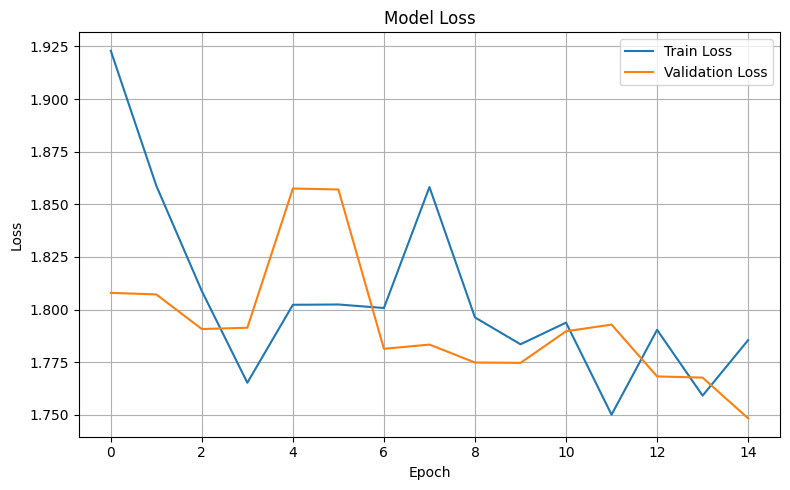

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.weights.h5")


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.models import model_from_json, Model
from tensorflow.keras.preprocessing import image
import os


In [12]:
# Load model architecture
with open("model.json", "r") as json_file:
    model_json = json_file.read()

model = model_from_json(model_json)

# Load model weights
model.load_weights("model_weights.weights.h5")
print("Model loaded successfully.")


Model loaded successfully.


In [13]:
def preprocess_image(img_path, target_size=(48, 48)):
    img = image.load_img(img_path, color_mode='grayscale', target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array


In [14]:
layer_name = 'conv2d_1'  # Replace with an actual layer name from your model
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)


In [15]:
for layer in model.layers:
    print(layer.name)


input_layer
conv2d
batch_normalization
activation
max_pooling2d
dropout
conv2d_1
batch_normalization_1
activation_1
max_pooling2d_1
dropout_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d_2
dropout_2
flatten
dense
activation_3
dropout_3
dense_1


In [25]:
def visualize_activation(img_path):
    img_array = preprocess_image(img_path)
    
    # Get feature maps
    feature_maps = intermediate_layer_model.predict(img_array)

    square = int(np.sqrt(feature_maps.shape[-1]))  # Grid size
    fig, axes = plt.subplots(square, square, figsize=(12, 12))
    fig.suptitle(f"Activation Maps for {os.path.basename(img_path)}", fontsize=16)

    for i in range(square * square):
        ax = axes[i // square, i % square]
        ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"visualizations/{os.path.basename(img_path).split('.')[0]}_activations.png")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


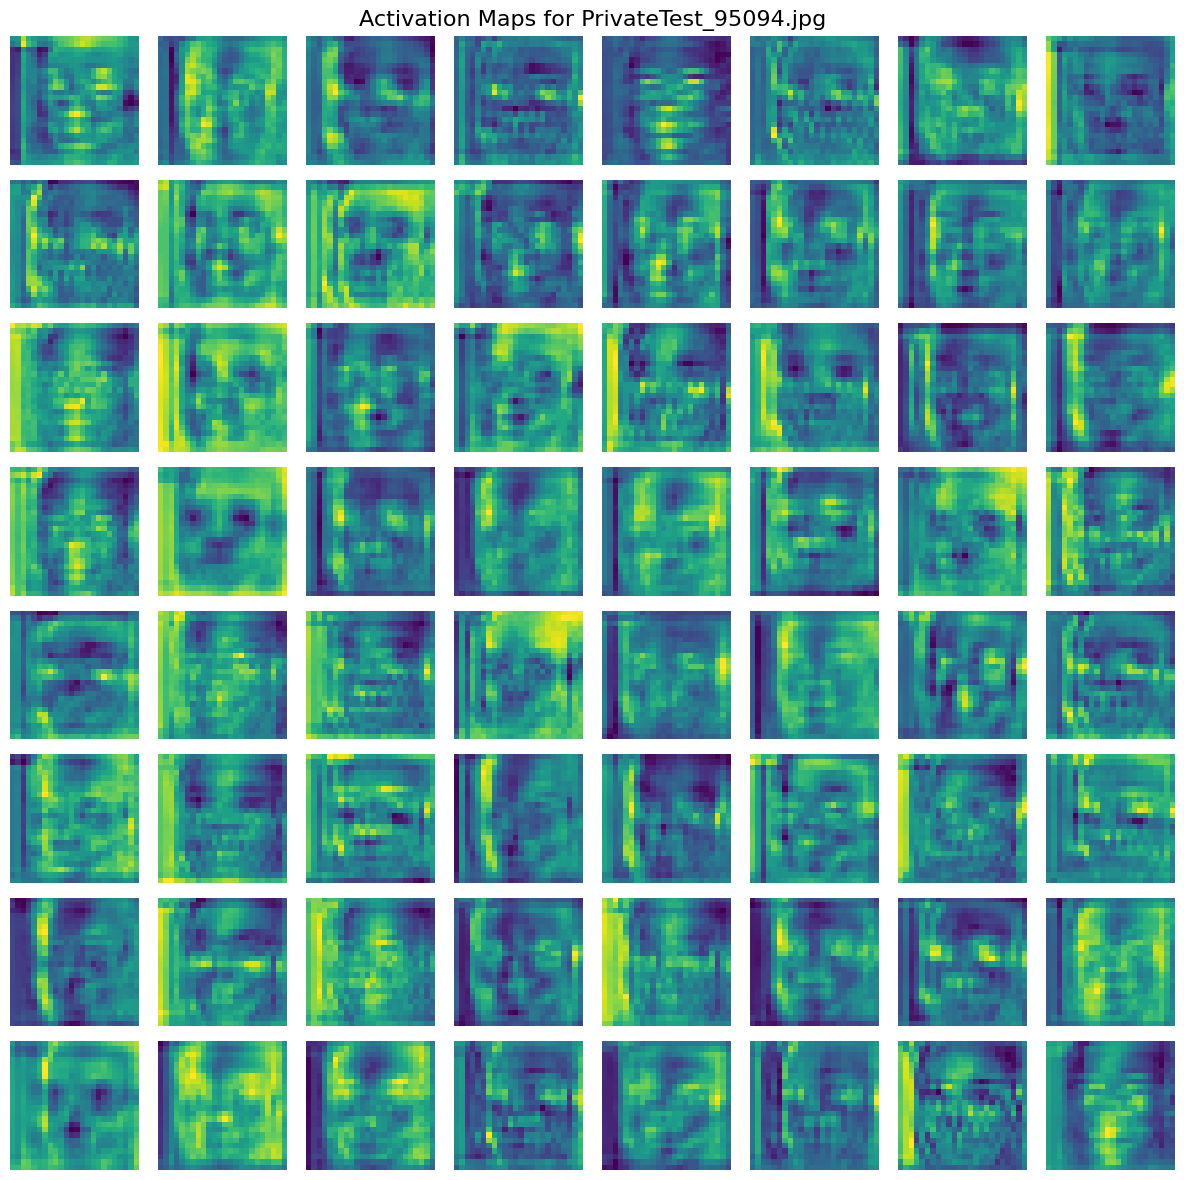

In [26]:
visualize_activation(r"C:\Users\harini p\OneDrive\Desktop\emotional detection\test\happy\PrivateTest_95094.jpg")


In [ ]:
# After training
model.save('models/emotion_model.h5')

